In [14]:
# E3.ipynb

import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [15]:
# To ensure reproducibility
np.random.seed(42)

# Read data from Excel file
file_path = 'E3.xlsx'
train_data = pd.read_excel(file_path, sheet_name='train')
test_data = pd.read_excel(file_path, sheet_name='test')

In [16]:
# Separate features and target variable in train data
X_train = train_data.drop(columns=['y'])
y_train = train_data['y']

# Separate features and target variable in test data
X_test = test_data.drop(columns=['y'])
y_test = test_data['y']

In [17]:
# # Adding outliers (UNCOMMENT ONLY WHEN REQUIRED! SEE THE PROBLEM STATEMENTs ...)
# X_train = np.array(list(X_train['x1']) + [X_train['x1'].mean() + x for x in np.random.randn(5)]).reshape(-1,1)
# y_train = np.array(list(y_train) + [y_train.max() + 4 + x for x in np.random.randn(5)])

In [18]:
# Use PolynomialFeatures to create features
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


In [19]:
print(X_train)

            x1
0     7.614286
1     7.621429
2     7.628571
3     7.642857
4     7.650000
..         ...
543  12.571429
544  12.578571
545  12.585714
546  12.592857
547  12.600000

[548 rows x 1 columns]


In [20]:
print(X_train_poly)

[[ 1.          7.61428571]
 [ 1.          7.62142857]
 [ 1.          7.62857143]
 ...
 [ 1.         12.58571429]
 [ 1.         12.59285714]
 [ 1.         12.6       ]]


In [21]:
# standardization of the data
scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

In [22]:
poly.get_feature_names_out()

array(['1', 'x1'], dtype=object)

In [23]:
####################################
# Save the augmented data set to a file for review

# Create dataframe with test data and additional features
# Get feature names
feature_names = poly.get_feature_names_out()
augmented_data = pd.DataFrame(X_train_poly, columns=feature_names)
augmented_data['y'] = train_data['y']

# # Write dataframe to CSV
augmented_data.to_csv('augmented_train_data.csv', index=False)
####################################
####################################
# Save the augmented data set to a file for review

# Create dataframe with test data and additional features
# Get feature names
feature_names = poly.get_feature_names_out()
augmented_data = pd.DataFrame(X_test_poly, columns=feature_names)
augmented_data['y'] = test_data['y']
# # Write dataframe to CSV
augmented_data.to_csv('augmented_test_data.csv', index=False)
####################################

In [24]:
# Algorithms
algorithms = {
    'Linear Regression': LinearRegression(),
    'SVM Regression poly': SVR(kernel='poly'),
    'SVM Regression rbf': SVR(kernel='rbf'),  # Adjust kernel as needed
    'RandomForest': RandomForestRegressor(),
    'XGBoost': GradientBoostingRegressor(),
    'knn': KNeighborsRegressor(),
    'Neural Network-10': MLPRegressor(hidden_layer_sizes=[10], max_iter=20000),
}

# Metric tables
metric_table_train = pd.DataFrame()
metric_table_test = pd.DataFrame()

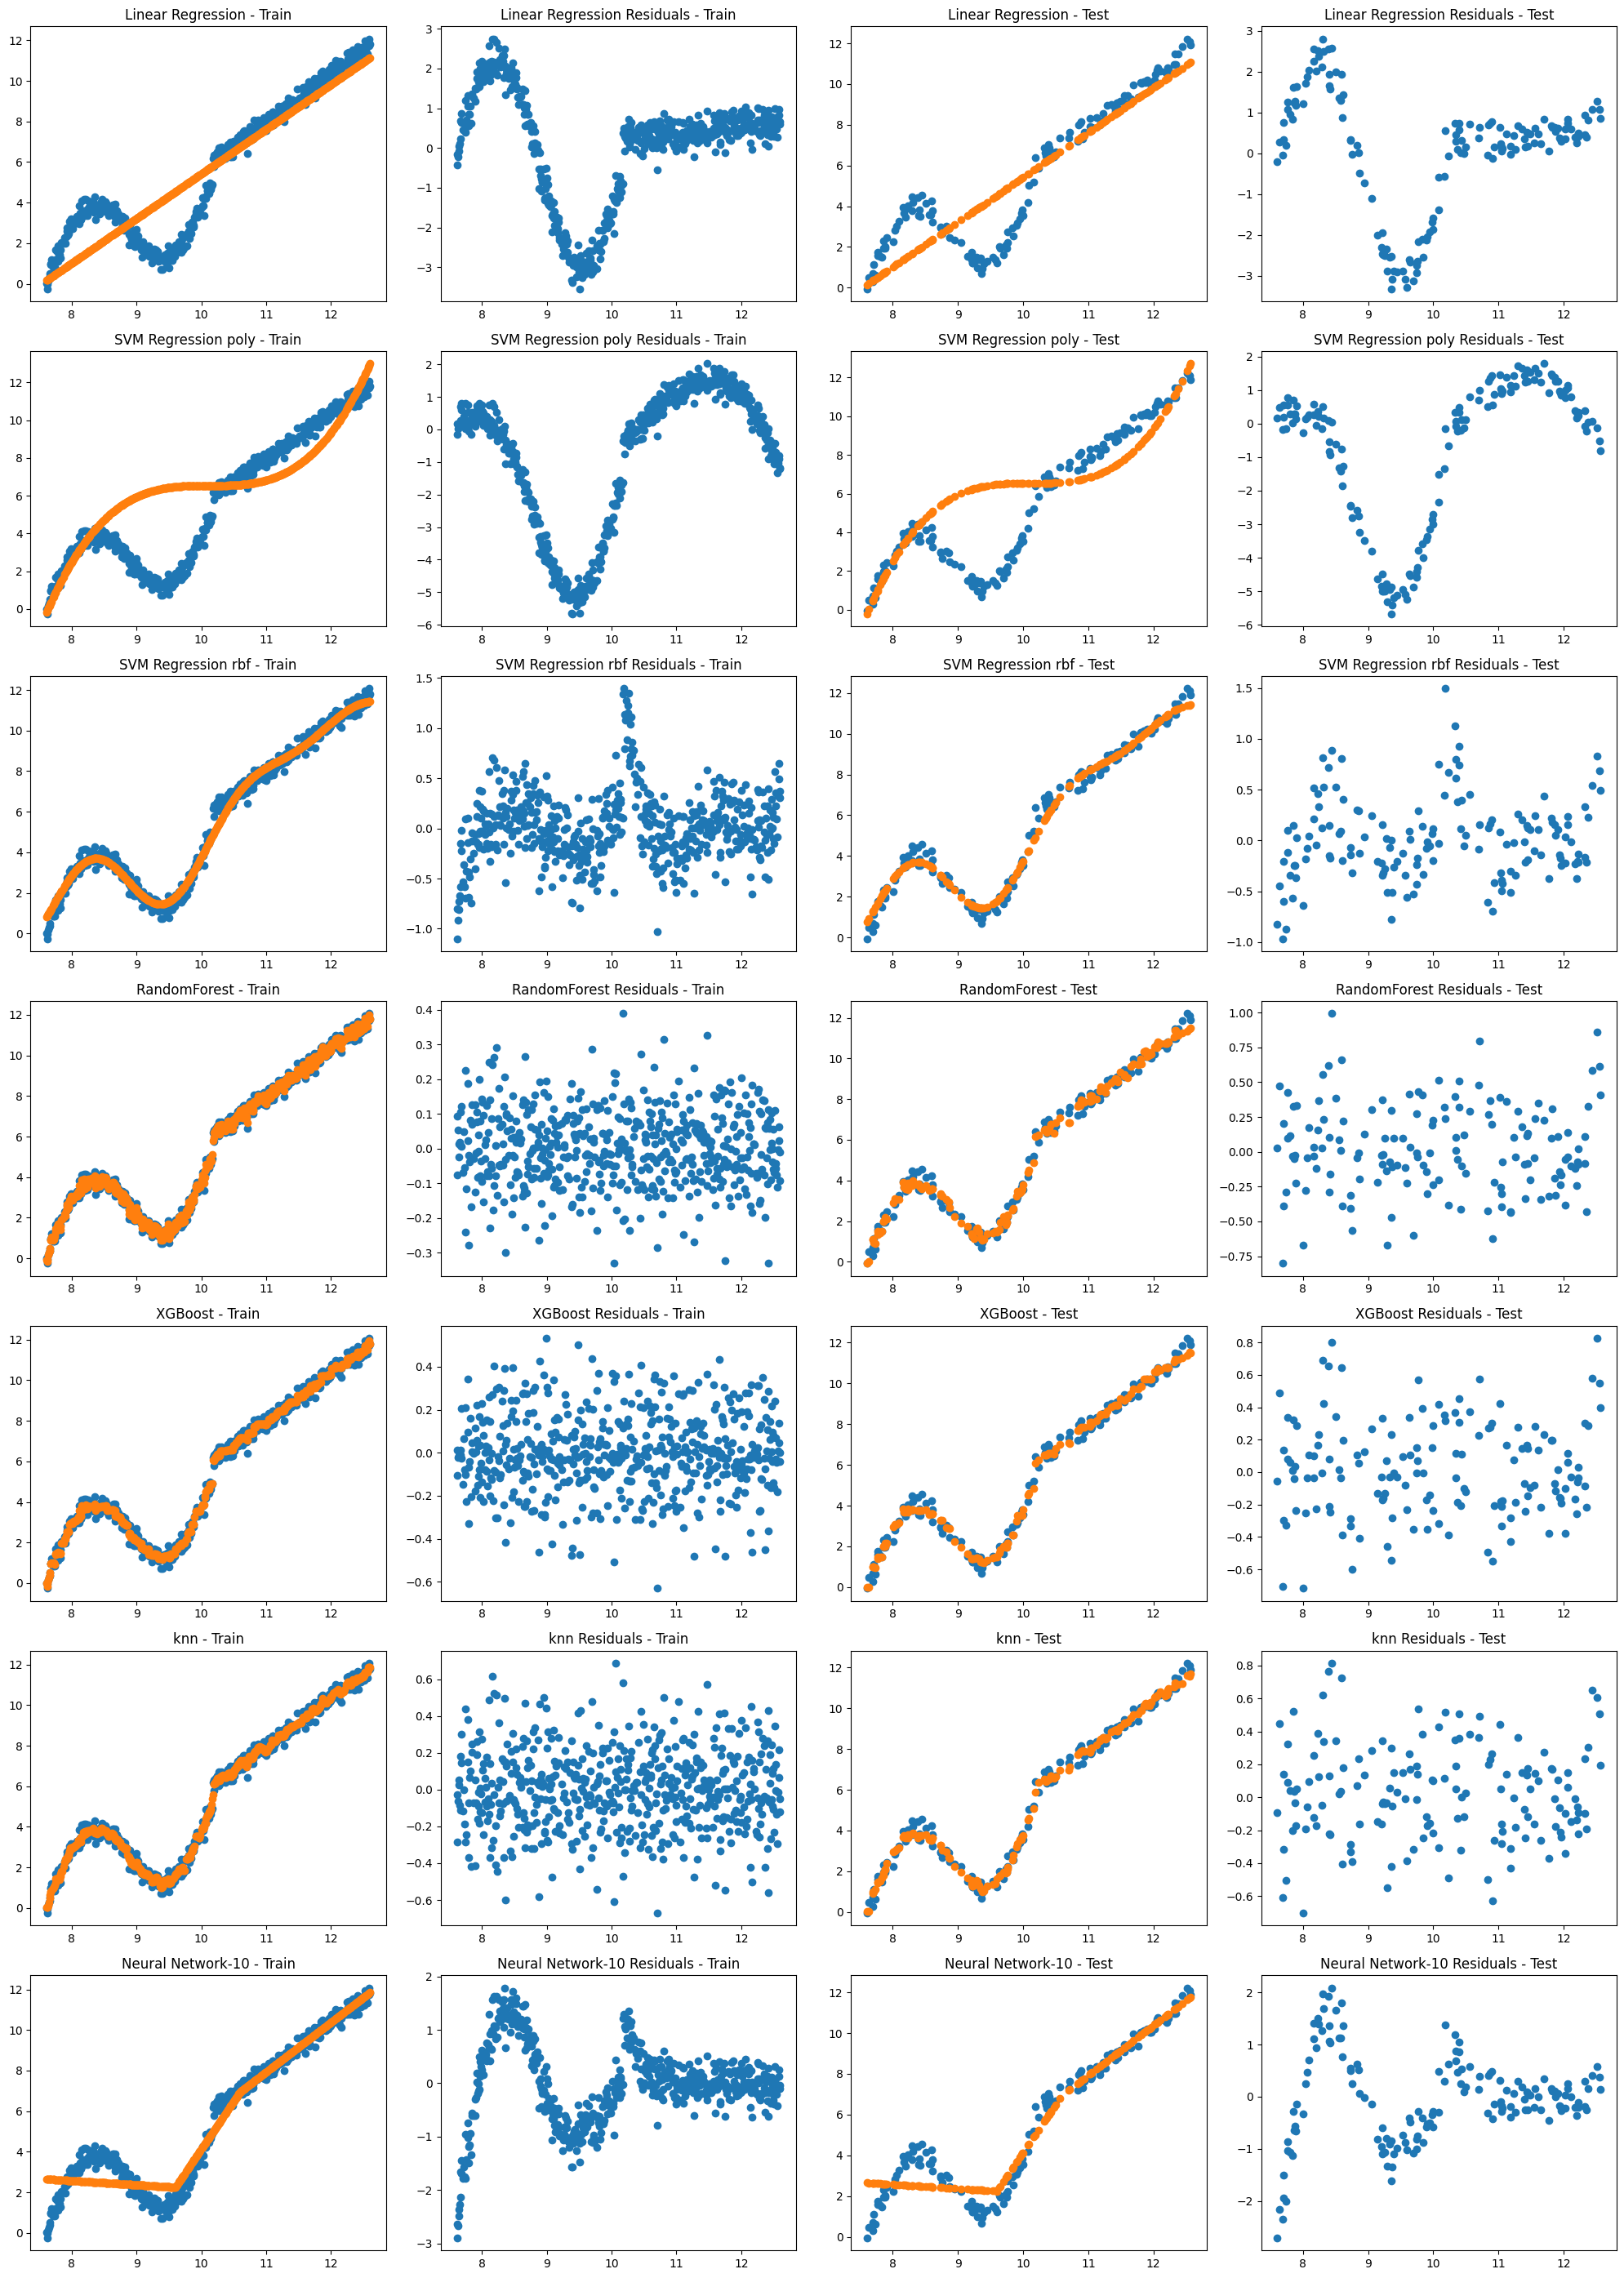

In [25]:
# Create a grid of subplots
fig, axs = plt.subplots(len(algorithms), 4, figsize=(20, 4 * len(algorithms)))
fig_row = -1

# Run the algorithms ... create metrics and plots
for algorithm_name, algorithm in algorithms.items():

    # Train model
    algorithm.fit(X_train_poly, y_train)

    # Train predictions
    y_train_pred = algorithm.predict(X_train_poly)

    # Test predictions
    y_test_pred = algorithm.predict(X_test_poly)

    # Train metrics
    r2_train = algorithm.score(X_train_poly, y_train)
    rmse_train = root_mean_squared_error(y_train, y_train_pred)

    # Test metrics
    r2_test = algorithm.score(X_test_poly, y_test)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)

    # Additional metrics using statsmodels for all algorithms
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    durbin_watson_stat_train = sm.stats.durbin_watson(residuals_train)
    jb_stat_train, jb_p_value_train, _, _ = sm.stats.jarque_bera(residuals_train)

    durbin_watson_stat_test = sm.stats.durbin_watson(residuals_test)
    jb_stat_test, jb_p_value_test, _, _ = sm.stats.jarque_bera(residuals_test)

    # Update metric tables
    metric_table_train.at[algorithm_name, 'R-squared'] = r2_train
    metric_table_train.at[algorithm_name, 'RMSE'] = rmse_train
    metric_table_train.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_train
    metric_table_train.at[algorithm_name, 'Jarque-Bera'] = jb_stat_train
    metric_table_train.at[algorithm_name, 'JB P-value'] = jb_p_value_train

    metric_table_test.at[algorithm_name, 'R-squared'] = r2_test
    metric_table_test.at[algorithm_name, 'RMSE'] = rmse_test
    metric_table_test.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_test
    metric_table_test.at[algorithm_name, 'Jarque-Bera'] = jb_stat_test
    metric_table_test.at[algorithm_name, 'JB P-value'] = jb_p_value_test

    # Create the plots
    fig_row = fig_row+1

    axs[fig_row, 0].scatter(X_train, y_train)
    axs[fig_row, 0].scatter(X_train, y_train_pred)
    axs[fig_row, 0].set_title(algorithm_name + " - Train")

    axs[fig_row, 1].scatter(X_train, residuals_train)
    axs[fig_row, 1].set_title(algorithm_name + " Residuals - Train")

    axs[fig_row, 2].scatter(X_test, y_test)
    axs[fig_row, 2].scatter(X_test, y_test_pred)
    axs[fig_row, 2].set_title(algorithm_name + " - Test")

    axs[fig_row, 3].scatter(X_test, residuals_test)
    axs[fig_row, 3].set_title(algorithm_name + " Residuals - Test")
############################

plt.tight_layout()
plt.show()

In [26]:
# Display the metrics' Tables
print("Metrics - Train Data:\n")
print(metric_table_train.to_string())
print("-------------------------------------------------")

print("Metrics - Test Data:\n")
print(metric_table_test.to_string())

Metrics - Train Data:

                     R-squared      RMSE  Durbin-Watson  Jarque-Bera    JB P-value
Linear Regression     0.833674  1.408923       0.059761    51.466506  6.670987e-12
SVM Regression poly   0.545415  2.329245       0.021942    68.878362  1.104724e-15
SVM Regression rbf    0.989564  0.352915       0.942916   104.342918  2.198990e-23
RandomForest          0.999001  0.109183       2.934608     3.504329  1.733982e-01
XGBoost               0.997146  0.184549       2.372918     1.046859  5.924852e-01
knn                   0.995929  0.220416       2.510498     0.705376  7.027965e-01
Neural Network-10     0.954519  0.736753       0.217396    30.374284  2.536927e-07
-------------------------------------------------
Metrics - Test Data:

                     R-squared      RMSE  Durbin-Watson  Jarque-Bera  JB P-value
Linear Regression     0.818068  1.501800       0.079118    12.500550    0.001930
SVM Regression poly   0.562991  2.327567       0.034813    23.409392    0.00000

we have to select beween RF XG KNN. The R2 are comaprable but the RMSE is least for Random forest by quite a margin. XG boost has its DW closest to 2. showing least auto correlation.  Knn give us the best normality distribution and its p value is 0.07 thus we cant reject H0(it is normal). For xg boost we have slight deviation from normal. Its p value is close to 0.06 thus we will go with normality. We reject random forest method. it has low p value.


thus it bolis down to knn and xg boost .  knn -  less r2,more rmse,more durbin,, less jb, ok p value. 
i will choose. knn as it has less durbin as eroor coorelation is less.
